In [67]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load and preprocess the data
train_df = pd.read_csv("data/titanic/train.csv")
serving_df = pd.read_csv("data/titanic/test.csv")


In [69]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
def preprocess(df):
    df = df.copy()
    
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)                     
    return df


In [47]:
preprocessed_train_df = preprocess(train_df)
preprocessed_serving_df = preprocess(serving_df)

In [48]:
input_features = list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")

print(f"Input features: {input_features}")

Input features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Ticket_number', 'Ticket_item']


In [32]:
# Prepare data and labels
X_train = preprocessed_train_df[input_features].values
y_train = preprocessed_train_df["Survived"].values
X_serving = preprocessed_serving_df[input_features].values


In [33]:
# Convert data to PyTorch tensors
def convert_to_tensor(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

In [49]:
X_train = convert_to_tensor(preprocessed_train_df[input_features]).values
y_train = preprocessed_train_df["Survived"].values
X_serving = convert_to_tensor(preprocessed_serving_df[input_features]).values

In [50]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add a new axis for compatibility
X_serving = torch.tensor(X_serving, dtype=torch.float32)


In [36]:
# # Normalize the data to range [0, 1] not required for pytorch
# X_train /= 255
# X_serving /= 255


In [51]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [52]:
# Define the model architecture
class TitanicModel(nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()
        self.fc1 = nn.Linear(len(input_features), 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [53]:
# Create the model and set the loss function and optimizer
model = TitanicModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())


In [55]:
# Training the model
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    train_dataset = data.TensorDataset(X_train, y_train)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = data.TensorDataset(X_val, y_val)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


In [57]:
# Train the model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=10, batch_size=32)

Epoch 1/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 2/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 3/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 4/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 5/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 6/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 7/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 8/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 9/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667
Epoch 10/10, Train Loss: nan, Val Loss: nan, Val Accuracy: 18.0667


In [58]:
# Make predictions on the test data
model.eval()
with torch.no_grad():
    predictions = model(X_serving).squeeze().numpy()


In [65]:
# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(targets.numpy())
            all_predictions.extend(predicted.numpy())
    return all_targets, all_predictions


In [66]:
# Evaluate on validation data
val_dataset = data.TensorDataset(X_val, y_val)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)

val_targets, val_predictions = evaluate_model(model, val_loader)

# Calculate accuracy
val_accuracy = np.mean(np.array(val_targets) == np.array(val_predictions))
print("Validation Accuracy:", val_accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_targets, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
class_report = classification_report(val_targets, val_predictions)
print("Classification Report:")
print(class_report)

Validation Accuracy: 0.6
Confusion Matrix:
[[54  0]
 [36  0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        54
         1.0       0.00      0.00      0.00        36

    accuracy                           0.60        90
   macro avg       0.30      0.50      0.37        90
weighted avg       0.36      0.60      0.45        90



/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

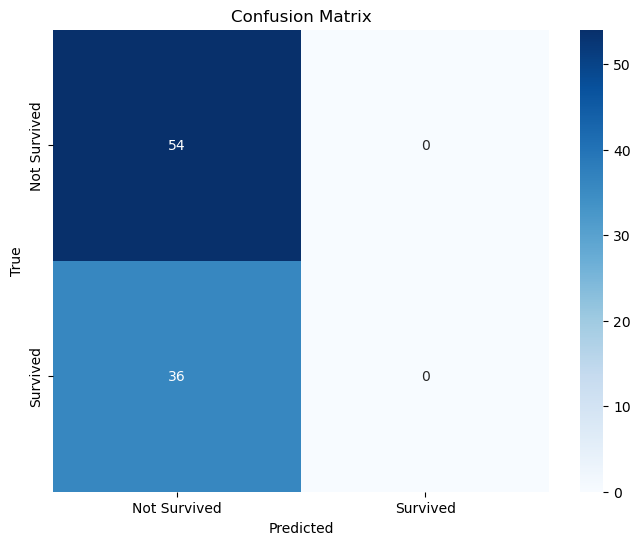

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        54
         1.0       0.00      0.00      0.00        36

    accuracy                           0.60        90
   macro avg       0.30      0.50      0.37        90
weighted avg       0.36      0.60      0.45        90



/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [68]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Calculate classification report
class_report = classification_report(val_targets, val_predictions)
print("Classification Report:")
print(class_report)

In [59]:
# Convert predictions to Kaggle format and save the submission
threshold = 0.5
kaggle_predictions = pd.DataFrame({
    "PassengerId": serving_df["PassengerId"],
    "Survived": (predictions >= threshold).astype(int)
})


In [60]:
def make_submission(kaggle_predictions):
    path = "data/titanic/submission.csv"
    kaggle_predictions.to_csv(path, index=False)
    print(f"Submission exported to {path}")


In [61]:
make_submission(kaggle_predictions)

Submission exported to data/titanic/submission.csv
